# Data Understanding and Preprocessing Open Bandit Dataset

---
This notebook demonstrates an example of conducting OPE of Bernoulli Thompson Sampling (BernoulliTS) as an evaluation policy. We use some OPE estimators and logged bandit data generated by running the Random policy (behavior policy) on the ZOZOTOWN platform. We also evaluate and compare the OPE performance (accuracy) of several estimators.

The example consists of the following four major steps:
- (1) Data Loading and Preprocessing

In [2]:
# needed when using Google Colab
# !pip install obp

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# import open bandit pipeline (obp)
import obp
from obp.dataset import OpenBanditDataset
from obp.policy import BernoulliTS
from obp.ope import (
    OffPolicyEvaluation,
    RegressionModel,
    DirectMethod,
    InverseProbabilityWeighting,
    DoublyRobust
)

In [4]:
# obp version
print(obp.__version__)

0.5.5


## (1) Data Loading and Preprocessing

`obp.dataset.OpenBanditDataset` is an easy-to-use data loader for Open Bandit Dataset.

It takes behavior policy ('bts' or 'random') and campaign ('all', 'men', or 'women') as inputs and provides dataset preprocessing.

In [5]:
# load and preprocess raw data in "All" campaign collected by the Random policy (behavior policy here)
# When `data_path` is not given, this class downloads the small-sized version of the Open Bandit Dataset.
dataset = OpenBanditDataset(behavior_policy='random', campaign='all')

INFO:obp.dataset.real:When `data_path` is not given, this class downloads the small-sized version of Open Bandit Dataset.


In [168]:
dataset_bts_all = OpenBanditDataset(behavior_policy='bts', campaign='all')

INFO:obp.dataset.real:When `data_path` is not given, this class downloads the small-sized version of Open Bandit Dataset.


In [6]:
dataset.data.head()

,timestamp,item_id,position,click,propensity_score,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user-item_affinity_0,...,user-item_affinity_70,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79
0,2019-11-24 00:00:34.762830+00:00,14,3,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,f97571b9c14a786aab269f0b427d2a85,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-11-24 00:00:53.965051+00:00,14,3,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-11-24 00:00:56.727734+00:00,27,3,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,9b2d331c329ceb74d3dcfb48d8798c78,270b3e1c052b4f2e9c90bf0ebeb84f34,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-11-24 00:02:17.189232+00:00,48,2,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-11-24 00:03:02.129117+00:00,36,2,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,f97571b9c14a786aab269f0b427d2a85,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
dataset.data_path

PosixPath('/Users/mudev/opt/anaconda3/envs/ope-obp/lib/python3.9/site-packages/obp/dataset/obd/random/all')

In [19]:
type(dataset.data)

pandas.core.frame.DataFrame

In [260]:
dataset.item_context.head()

,item_id,item_feature_0,item_feature_1,item_feature_2,item_feature_3
0,0,-0.499172,aed790911d0344f149be2fb9470d6f0a,67503f4af781d4037a8bac5e22549edd,5c1e29f902c3ad66e0ff9f6020b1aa0b
1,1,-0.543775,31af389431e50a8fcd6470aeeb7951f8,67503f4af781d4037a8bac5e22549edd,5c1e29f902c3ad66e0ff9f6020b1aa0b
2,2,0.972752,31af389431e50a8fcd6470aeeb7951f8,84da86f2aa5e816a473e4065f137bfa9,1ead5eb1766472d5bbe45ef0d5654a59
3,3,-0.521473,62dc7dd3bfeff6123b2f6f243da49a17,baf3941793166b612fd495e7ee5f9111,f56faf88e4759846197592d0216dd55b
4,4,1.909430,e2d1f9aa026708d54e048afce24cd2fe,1c267fe1a67f13b0417f8cf83c79cd7a,1ead5eb1766472d5bbe45ef0d5654a59


In [21]:
type(dataset.item_context)

pandas.core.frame.DataFrame

### Dataset Understanding



#### Load Raw Data

In [11]:
from pathlib import Path
import pandas as pd
from obp.dataset import OpenBanditDataset

data_path = Path('/Users/mudev/Library/CloudStorage/OneDrive-Personal/Machine-Learning/LJMU-IIITB/LJMU-MS/code/zr-obp/obd/random/all/all.csv')

raw_dataset = pd.read_csv(data_path, index_col=0)

In [12]:
raw_dataset.head()

,timestamp,item_id,position,click,propensity_score,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user-item_affinity_0,...,user-item_affinity_70,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79
0,2019-11-24 00:00:34.762830+00:00,14,3,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,f97571b9c14a786aab269f0b427d2a85,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-11-24 00:00:53.965051+00:00,14,3,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-11-24 00:00:56.727734+00:00,27,3,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,9b2d331c329ceb74d3dcfb48d8798c78,270b3e1c052b4f2e9c90bf0ebeb84f34,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-11-24 00:02:17.189232+00:00,48,2,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-11-24 00:03:02.129117+00:00,36,2,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,f97571b9c14a786aab269f0b427d2a85,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
type(raw_dataset)

pandas.core.frame.DataFrame

In [36]:
item_data_path = Path('/Users/mudev/Library/CloudStorage/OneDrive-Personal/Machine-Learning/LJMU-IIITB/LJMU-MS/code/zr-obp/obd/random/all/item_context.csv')

raw_item_dataset = pd.read_csv(item_data_path, index_col=0)

In [37]:
raw_item_dataset.head()

,item_id,item_feature_0,item_feature_1,item_feature_2,item_feature_3
0,0,-0.499172,aed790911d0344f149be2fb9470d6f0a,67503f4af781d4037a8bac5e22549edd,5c1e29f902c3ad66e0ff9f6020b1aa0b
1,1,-0.543775,31af389431e50a8fcd6470aeeb7951f8,67503f4af781d4037a8bac5e22549edd,5c1e29f902c3ad66e0ff9f6020b1aa0b
2,2,0.972752,31af389431e50a8fcd6470aeeb7951f8,84da86f2aa5e816a473e4065f137bfa9,1ead5eb1766472d5bbe45ef0d5654a59
3,3,-0.521473,62dc7dd3bfeff6123b2f6f243da49a17,baf3941793166b612fd495e7ee5f9111,f56faf88e4759846197592d0216dd55b
4,4,1.909430,e2d1f9aa026708d54e048afce24cd2fe,1c267fe1a67f13b0417f8cf83c79cd7a,1ead5eb1766472d5bbe45ef0d5654a59


In [23]:
# checking if dataset in package and raw file is same
from pandas.util.testing import assert_frame_equal

In [33]:
assert_frame_equal(dataset.data, raw_dataset)

In [39]:
assert_frame_equal(dataset.item_context, raw_item_dataset)

#### overall

In [ ]:
# pip install tensorflow-data-validation

#### Reward

In [42]:
type(dataset.reward), len(dataset.reward)

(numpy.ndarray, 10000)

In [29]:
# CLICK THROUGH RATE
sum(dataset.reward) * 100 / len(dataset.reward)

0.38

In [51]:
pd.DataFrame(dataset.reward).describe(include='all', percentiles=[0.75, 0.99, 0.995, 0.9999])

,0
count,10000.00000
mean,0.00380
std,0.06153
min,0.00000
50%,0.00000
75%,0.00000
99%,0.00000
99.5%,0.00000
99.99%,1.00000
max,1.00000


<AxesSubplot:ylabel='Frequency'>

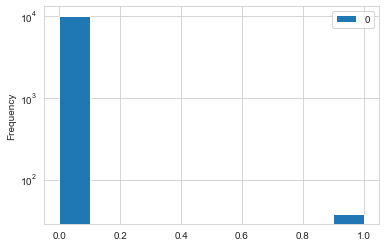

In [52]:
pd.DataFrame(dataset.reward).plot(kind='hist', logy=True)

#### position and reward interaction

from plots its evident that reward is dependent on the position
the left (id=0) and center (id=1) has higher reward than the right position (id=2)
Henceforth off policy estimators with combinitorial/slate action space should perform better

In [100]:
# ZOZOTOWN recommendation interface has three positions
# (please see https://github.com/st-tech/zr-obp/blob/master/images/recommended_fashion_items.png)
dataset.len_list

3

In [87]:
# position in data
# 1 - 3
pd.DataFrame(dataset.data.position).describe()

,position
count,10000.000000
mean,1.994400
std,0.811686
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,3.000000


In [88]:
# preprocessed position
# 0 - 2
pd.DataFrame(dataset.position).describe()

,0
count,10000.000000
mean,0.994400
std,0.811686
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


<AxesSubplot:ylabel='Frequency'>

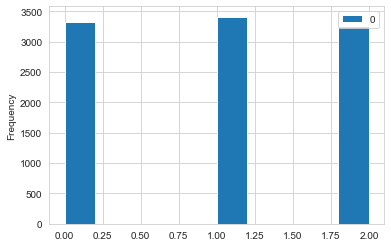

In [66]:
# position is equally distributed
pd.DataFrame(dataset.position).plot(kind='hist')

<AxesSubplot:>

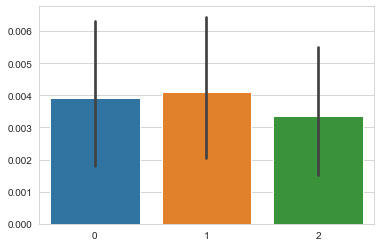

In [78]:
import seaborn as sns

sns.barplot(x = dataset.position, y=dataset.reward)

#### probability / propensity score

random policy => 1/80 chance to pick any arm

In [79]:
type(dataset.pscore), len(dataset.pscore)

(numpy.ndarray, 10000)

In [85]:
1/dataset.n_actions

0.0125

In [80]:
dataset.pscore[:5]

array([0.0125, 0.0125, 0.0125, 0.0125, 0.0125])

<AxesSubplot:>

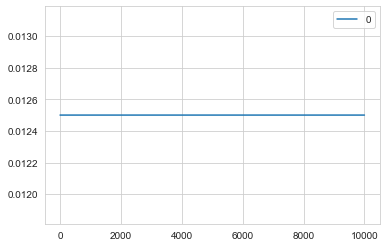

In [86]:
pd.DataFrame(dataset.pscore).plot()

#### User Features / context

features are hashed to preserve privacy of the users
these features contains user demographic details such as age, gender, location etc.

In [92]:
user_cols = dataset.data.columns.str.contains("user_feature")

In [93]:
dataset.data.loc[:, user_cols].head()

,user_feature_0,user_feature_1,user_feature_2,user_feature_3
0,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,f97571b9c14a786aab269f0b427d2a85
1,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8
2,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,9b2d331c329ceb74d3dcfb48d8798c78,270b3e1c052b4f2e9c90bf0ebeb84f34
3,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8
4,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,f97571b9c14a786aab269f0b427d2a85


In [94]:
dataset.data.loc[:, user_cols].describe(include='all')

,user_feature_0,user_feature_1,user_feature_2,user_feature_3
count,10000,10000,10000,10000
unique,3,5,8,8
top,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,9bde591ffaab8d54c457448e4dca6f53
freq,8200,8308,2437,3681


In [95]:
# total unique user features
3 + 5 + 8 + 8

24

##### `context` is the one-hot encoded matrix from `user_features (0 to 3)` in raw data

In [104]:
dataset.dim_context

20

In [105]:
type(dataset.context), dataset.context.shape

(numpy.ndarray, (10000, 20))

In [106]:
dataset.context[:5]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]],
      dtype=uint8)

#### timestamp

data collection range: 2019-11-24 to 2019-12-01

time range is low, henceforth weighting reward on time might not be useful!

In [120]:
dataset.data.timestamp[:5]

0    2019-11-24 00:00:34.762830+00:00
1    2019-11-24 00:00:53.965051+00:00
2    2019-11-24 00:00:56.727734+00:00
3    2019-11-24 00:02:17.189232+00:00
4    2019-11-24 00:03:02.129117+00:00
Name: timestamp, dtype: object

In [139]:
pd.to_datetime(dataset.data.timestamp).dtypes

datetime64[ns, UTC]

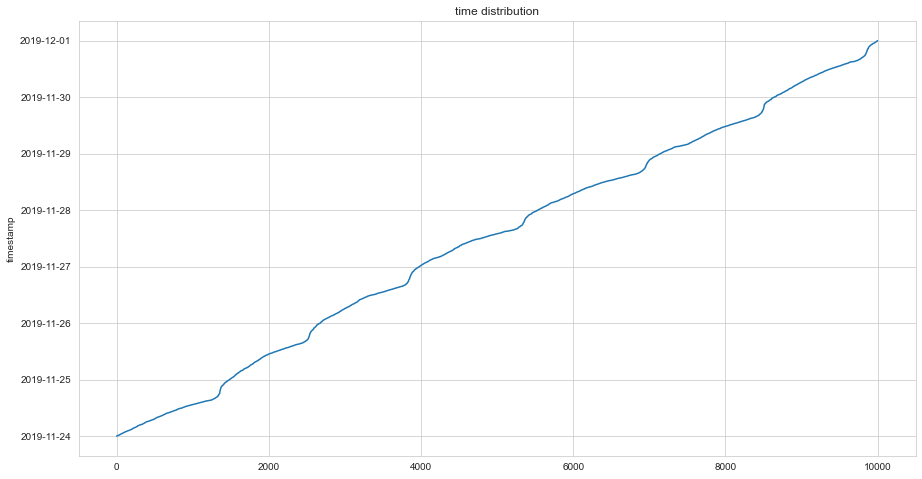

In [138]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
plt.title("time distribution")
sns.lineplot(data=pd.to_datetime(dataset.data.timestamp))
plt.show()

#### Item-id

TODO:
- item-id over time-steps
- item-id over positions



In [141]:
dataset.data.item_id.describe()

count    10000.000000
mean        39.287000
std         23.163931
min          0.000000
25%         19.000000
50%         40.000000
75%         59.000000
max         79.000000
Name: item_id, dtype: float64

#### Plot Action Distribution for both Random and BerTS logging policies

can display for different campaigns => all, men, women

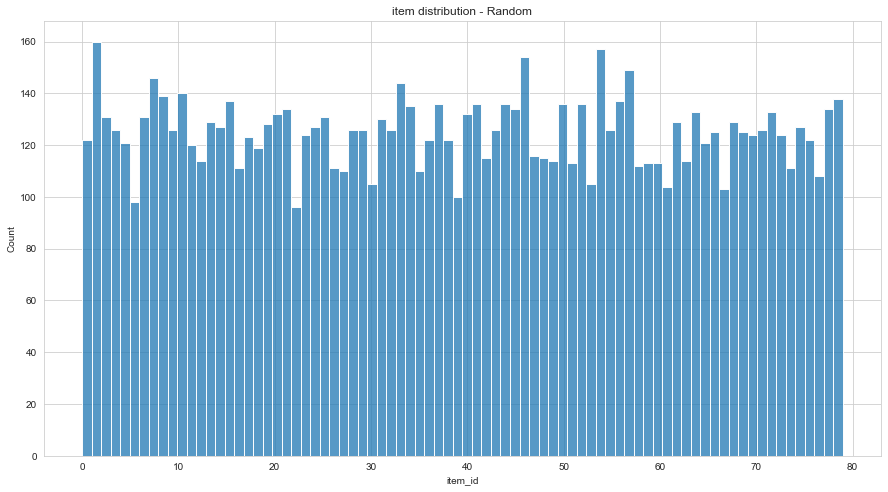

In [176]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
plt.title("item distribution - Random")
sns.histplot(x=dataset.data.item_id, bins=80)
plt.show()

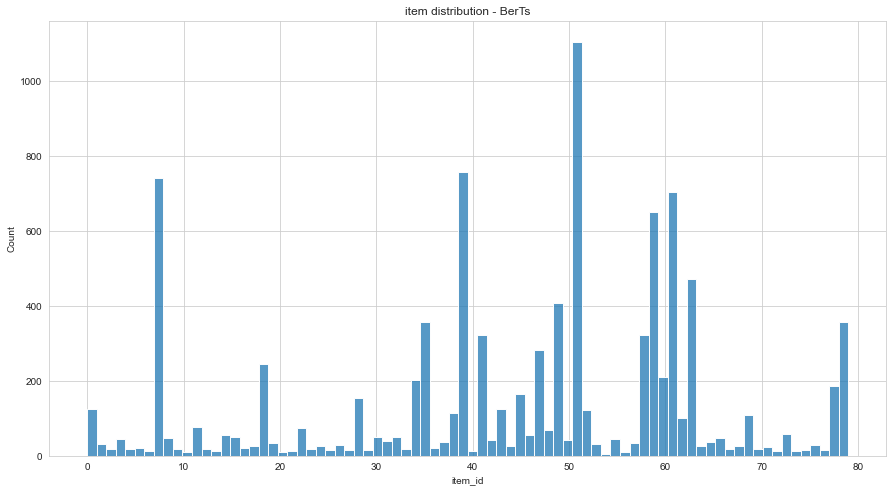

In [175]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
plt.title("item distribution - BerTs")
sns.histplot(x=dataset_bts_all.data.item_id, bins=80)
plt.show()

#### Item / Action Context

item_feature_0 => continuous feature

item_feature_(1-3) => categorical feature - hashed

In [98]:
dataset.item_context.head()

,item_id,item_feature_0,item_feature_1,item_feature_2,item_feature_3
0,0,-0.499172,aed790911d0344f149be2fb9470d6f0a,67503f4af781d4037a8bac5e22549edd,5c1e29f902c3ad66e0ff9f6020b1aa0b
1,1,-0.543775,31af389431e50a8fcd6470aeeb7951f8,67503f4af781d4037a8bac5e22549edd,5c1e29f902c3ad66e0ff9f6020b1aa0b
2,2,0.972752,31af389431e50a8fcd6470aeeb7951f8,84da86f2aa5e816a473e4065f137bfa9,1ead5eb1766472d5bbe45ef0d5654a59
3,3,-0.521473,62dc7dd3bfeff6123b2f6f243da49a17,baf3941793166b612fd495e7ee5f9111,f56faf88e4759846197592d0216dd55b
4,4,1.909430,e2d1f9aa026708d54e048afce24cd2fe,1c267fe1a67f13b0417f8cf83c79cd7a,1ead5eb1766472d5bbe45ef0d5654a59


In [145]:
type(dataset.item_context)

pandas.core.frame.DataFrame

In [75]:
dataset.item_context.describe(include='all')

,item_id,item_feature_0,item_feature_1,item_feature_2,item_feature_3
count,80.0000,8.000000e+01,80,80,80
unique,NaN,NaN,12,21,7
top,NaN,NaN,aed790911d0344f149be2fb9470d6f0a,67503f4af781d4037a8bac5e22549edd,f56faf88e4759846197592d0216dd55b
freq,NaN,NaN,14,11,27
mean,39.5000,-1.276756e-16,NaN,NaN,NaN
std,23.2379,1.006309e+00,NaN,NaN,NaN
min,0.0000,-1.056718e+00,NaN,NaN,NaN
25%,19.7500,-6.218319e-01,NaN,NaN,NaN
50%,39.5000,-4.322660e-01,NaN,NaN,NaN
75%,59.2500,3.482995e-01,NaN,NaN,NaN


##### `action_context` is derived from `item_context` column in raw dataframe
and contains label-encoded categorical features `item_feature (1 to 3)` and numerical feature `item_feature0`

In [147]:
type(dataset.action_context), len(dataset.action_context)

(numpy.ndarray, 80)

In [148]:
dataset.action_context[:5]

array([[ 5.        , 10.        ,  4.        , -0.49917163],
       [ 1.        , 10.        ,  4.        , -0.54377537],
       [ 1.        , 12.        ,  1.        ,  0.97275186],
       [ 2.        , 15.        ,  6.        , -0.5214735 ],
       [10.        ,  1.        ,  1.        ,  1.90943043]])

In [149]:
pd.DataFrame(dataset.action_context).describe(include='all')

,0,1,2,3
count,80.000000,80.00000,80.000000,8.000000e+01
mean,4.412500,11.42500,3.712500,-1.276756e-16
std,3.212687,5.96355,2.200079,1.006309e+00
min,0.000000,0.00000,0.000000,-1.056718e+00
25%,2.000000,6.00000,1.000000,-6.218319e-01
50%,4.000000,12.00000,4.000000,-4.322660e-01
75%,7.000000,17.00000,6.000000,3.482995e-01
max,11.000000,20.00000,6.000000,3.782788e+00


#### User Item Affinity

**Definition:**
- user-item affinity scores induced by the number of past clicks observed between each user-item pair.
- can be greater than 1

**Understanding for Random Dataset:**
- checked for user-item_affinity => 1,2,3,4,5,52
- couldn't find any example where item/action with affinity-score=1 is selected!
- because the dataset is random

**Understanding for BerTS Dataset:**
- checked for user-item_affinity => 5
- couldn't find any example where item/action with affinity-score=1 is selected!


**Analysis required to understand correlation between user-item-affinity, selected-item and clicks!**



In [150]:
dataset.data.columns

Index(['timestamp', 'item_id', 'position', 'click', 'propensity_score',
       'user_feature_0', 'user_feature_1', 'user_feature_2', 'user_feature_3',
       'user-item_affinity_0', 'user-item_affinity_1', 'user-item_affinity_2',
       'user-item_affinity_3', 'user-item_affinity_4', 'user-item_affinity_5',
       'user-item_affinity_6', 'user-item_affinity_7', 'user-item_affinity_8',
       'user-item_affinity_9', 'user-item_affinity_10',
       'user-item_affinity_11', 'user-item_affinity_12',
       'user-item_affinity_13', 'user-item_affinity_14',
       'user-item_affinity_15', 'user-item_affinity_16',
       'user-item_affinity_17', 'user-item_affinity_18',
       'user-item_affinity_19', 'user-item_affinity_20',
       'user-item_affinity_21', 'user-item_affinity_22',
       'user-item_affinity_23', 'user-item_affinity_24',
       'user-item_affinity_25', 'user-item_affinity_26',
       'user-item_affinity_27', 'user-item_affinity_28',
       'user-item_affinity_29', 'user-item_

In [151]:
user_item_affinity_cols = dataset.data.columns.str.contains("user-item_affinity")

In [152]:
dataset.data.loc[:, user_item_affinity_cols].head()

,user-item_affinity_0,user-item_affinity_1,user-item_affinity_2,user-item_affinity_3,user-item_affinity_4,user-item_affinity_5,user-item_affinity_6,user-item_affinity_7,user-item_affinity_8,user-item_affinity_9,...,user-item_affinity_70,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [154]:
dataset.data.loc[:, user_item_affinity_cols].describe(include='all', percentiles=[0.75, 0.99, 0.995, 0.9999])

,user-item_affinity_0,user-item_affinity_1,user-item_affinity_2,user-item_affinity_3,user-item_affinity_4,user-item_affinity_5,user-item_affinity_6,user-item_affinity_7,user-item_affinity_8,user-item_affinity_9,...,user-item_affinity_70,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79
count,10000.0000,10000.000000,10000.0000,10000.0,10000.0000,10000.000000,10000.000000,10000.000000,10000.0000,10000.0000,...,10000.000000,10000.000000,10000.000000,10000.0,10000.0000,10000.0000,10000.0,10000.0,10000.0000,10000.00000
mean,0.0001,0.000200,0.0001,0.0,0.0001,0.004300,0.000400,0.000300,0.0001,0.0001,...,0.000500,0.003000,0.000200,0.0,0.0001,0.0001,0.0,0.0,0.0001,0.00070
std,0.0100,0.014141,0.0100,0.0,0.0100,0.066947,0.019997,0.017319,0.0100,0.0100,...,0.022356,0.059928,0.014141,0.0,0.0100,0.0100,0.0,0.0,0.0100,0.02645
min,0.0000,0.000000,0.0000,0.0,0.0000,0.000000,0.000000,0.000000,0.0000,0.0000,...,0.000000,0.000000,0.000000,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.00000
50%,0.0000,0.000000,0.0000,0.0,0.0000,0.000000,0.000000,0.000000,0.0000,0.0000,...,0.000000,0.000000,0.000000,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.00000
75%,0.0000,0.000000,0.0000,0.0,0.0000,0.000000,0.000000,0.000000,0.0000,0.0000,...,0.000000,0.000000,0.000000,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.00000
99%,0.0000,0.000000,0.0000,0.0,0.0000,0.000000,0.000000,0.000000,0.0000,0.0000,...,0.000000,0.000000,0.000000,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.00000
99.5%,0.0000,0.000000,0.0000,0.0,0.0000,0.000000,0.000000,0.000000,0.0000,0.0000,...,0.000000,0.000000,0.000000,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.00000
99.99%,0.0001,1.000000,0.0001,0.0,0.0001,1.000100,1.000000,1.000000,0.0001,0.0001,...,1.000000,2.000000,1.000000,0.0,0.0001,0.0001,0.0,0.0,0.0001,1.00000
max,1.0000,1.000000,1.0000,0.0,1.0000,2.000000,1.000000,1.000000,1.0000,1.0000,...,1.000000,2.000000,1.000000,0.0,1.0000,1.0000,0.0,0.0,1.0000,1.00000


In [167]:
dataset.data[dataset.data['user-item_affinity_5'] != 0]

,timestamp,item_id,position,click,propensity_score,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user-item_affinity_0,...,user-item_affinity_70,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79
125,2019-11-24 01:56:59.978675+00:00,51,2,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,9bde591ffaab8d54c457448e4dca6f53,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
586,2019-11-24 08:33:38.667529+00:00,38,1,1,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,719dab53a7560218a9d1f96b25d6fa32,9bde591ffaab8d54c457448e4dca6f53,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
674,2019-11-24 09:50:45.589584+00:00,45,1,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,9bde591ffaab8d54c457448e4dca6f53,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
868,2019-11-24 12:04:35.448832+00:00,30,3,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,7bc94a2da491829b777c49c4b5e480f2,9bde591ffaab8d54c457448e4dca6f53,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
881,2019-11-24 12:14:34.808523+00:00,17,1,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,9b2d331c329ceb74d3dcfb48d8798c78,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1068,2019-11-24 13:57:16.269236+00:00,38,3,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,06128286bcc64b6a4b0fb7bc0328fe17,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1107,2019-11-24 14:17:14.017350+00:00,54,1,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,f1c2d6a32ec39249160cf784b63f4c6f,2723d2eb8bba04e0362098011fa3997b,f97571b9c14a786aab269f0b427d2a85,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1264,2019-11-24 15:34:34.754613+00:00,33,2,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,9bde591ffaab8d54c457448e4dca6f53,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1800,2019-11-25 06:59:30.459636+00:00,36,2,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,9bde591ffaab8d54c457448e4dca6f53,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2619,2019-11-25 22:36:13.001781+00:00,8,3,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,9b2d331c329ceb74d3dcfb48d8798c78,9bde591ffaab8d54c457448e4dca6f53,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### BerTs

In [177]:
user_item_affinity_cols = dataset.data.columns.str.contains("user-item_affinity")

In [178]:
dataset_bts_all.data.loc[:, user_item_affinity_cols].head()

,user-item_affinity_0,user-item_affinity_1,user-item_affinity_2,user-item_affinity_3,user-item_affinity_4,user-item_affinity_5,user-item_affinity_6,user-item_affinity_7,user-item_affinity_8,user-item_affinity_9,...,user-item_affinity_70,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [179]:
dataset_bts_all.data.loc[:, user_item_affinity_cols].describe(include='all', percentiles=[0.75, 0.99, 0.995, 0.9999])

,user-item_affinity_0,user-item_affinity_1,user-item_affinity_2,user-item_affinity_3,user-item_affinity_4,user-item_affinity_5,user-item_affinity_6,user-item_affinity_7,user-item_affinity_8,user-item_affinity_9,...,user-item_affinity_70,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79
count,10000.0,10000.0000,10000.0000,10000.0,10000.0,10000.000000,10000.000000,10000.000000,10000.0000,10000.0,...,10000.00000,10000.000000,10000.000000,10000.0000,10000.000000,10000.0000,10000.0,10000.000000,10000.0,10000.000000
mean,0.0,0.0001,0.0001,0.0,0.0,0.004700,0.000600,0.000200,0.0001,0.0,...,0.00070,0.003400,0.000400,0.0001,0.000300,0.0001,0.0,0.000300,0.0,0.000400
std,0.0,0.0100,0.0100,0.0,0.0,0.076671,0.024489,0.014141,0.0100,0.0,...,0.02645,0.061553,0.019997,0.0100,0.017319,0.0100,0.0,0.017319,0.0,0.019997
min,0.0,0.0000,0.0000,0.0,0.0,0.000000,0.000000,0.000000,0.0000,0.0,...,0.00000,0.000000,0.000000,0.0000,0.000000,0.0000,0.0,0.000000,0.0,0.000000
50%,0.0,0.0000,0.0000,0.0,0.0,0.000000,0.000000,0.000000,0.0000,0.0,...,0.00000,0.000000,0.000000,0.0000,0.000000,0.0000,0.0,0.000000,0.0,0.000000
75%,0.0,0.0000,0.0000,0.0,0.0,0.000000,0.000000,0.000000,0.0000,0.0,...,0.00000,0.000000,0.000000,0.0000,0.000000,0.0000,0.0,0.000000,0.0,0.000000
99%,0.0,0.0000,0.0000,0.0,0.0,0.000000,0.000000,0.000000,0.0000,0.0,...,0.00000,0.000000,0.000000,0.0000,0.000000,0.0000,0.0,0.000000,0.0,0.000000
99.5%,0.0,0.0000,0.0000,0.0,0.0,0.000000,0.000000,0.000000,0.0000,0.0,...,0.00000,0.000000,0.000000,0.0000,0.000000,0.0000,0.0,0.000000,0.0,0.000000
99.99%,0.0,0.0001,0.0001,0.0,0.0,2.000100,1.000000,1.000000,0.0001,0.0,...,1.00000,2.000000,1.000000,0.0001,1.000000,0.0001,0.0,1.000000,0.0,1.000000
max,0.0,1.0000,1.0000,0.0,0.0,3.000000,1.000000,1.000000,1.0000,0.0,...,1.00000,2.000000,1.000000,1.0000,1.000000,1.0000,0.0,1.000000,0.0,1.000000


In [180]:
dataset_bts_all.data[dataset_bts_all.data['user-item_affinity_5'] != 0]

,timestamp,item_id,position,click,propensity_score,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user-item_affinity_0,...,user-item_affinity_70,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79
123,2019-11-24 01:46:22.033796+00:00,61,3,0,0.215650,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,f97571b9c14a786aab269f0b427d2a85,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
379,2019-11-24 05:57:21.506020+00:00,51,2,0,0.046690,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,9bde591ffaab8d54c457448e4dca6f53,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
441,2019-11-24 06:50:40.098016+00:00,59,2,0,0.072200,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,719dab53a7560218a9d1f96b25d6fa32,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
888,2019-11-24 12:17:13.492901+00:00,1,1,0,0.000670,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,7bc94a2da491829b777c49c4b5e480f2,06128286bcc64b6a4b0fb7bc0328fe17,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1064,2019-11-24 13:46:26.282033+00:00,0,1,0,0.082020,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,7bc94a2da491829b777c49c4b5e480f2,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1077,2019-11-24 13:53:09.801100+00:00,63,3,0,0.097635,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1138,2019-11-24 14:17:12.565004+00:00,63,3,0,0.108510,81ce123cbb5bd8ce818f60fb3586bba5,2d03db5543b14483e52d761760686b64,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1211,2019-11-24 15:01:18.593513+00:00,0,1,0,0.278625,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1382,2019-11-24 18:23:43.083603+00:00,63,1,0,0.050365,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,719dab53a7560218a9d1f96b25d6fa32,06128286bcc64b6a4b0fb7bc0328fe17,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1491,2019-11-24 23:27:30.636179+00:00,78,3,0,0.010445,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,9b2d331c329ceb74d3dcfb48d8798c78,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Properties

In [181]:
# Size of the logged bandit data
dataset.n_rounds

10000

In [182]:
# number of actions
dataset.n_actions

80

In [186]:
# Dimensions of context vectors
# one-hot encoded matrix of user-context columns
dataset.dim_context

20

In [188]:
# Length of recommendation lists, slate size
# left, right and center
dataset.len_list

3

### obtain_batch_bandit_feedback

the logged bandit dataset is collected by the behavior policy as follows.

$ \mathcal{D}_b := \{(x_i,a_i,r_i)\}$  where $(x,a,r) \sim p(x)\pi_b(a | x)p(r | x,a) $

In [190]:
# obtain logged bandit feedback generated by behavior policy
bandit_feedback = dataset.obtain_batch_bandit_feedback()

In [191]:
type(bandit_feedback)

dict

In [192]:
# `bandit_feedback` is a dictionary storing logged bandit feedback
bandit_feedback.keys()

dict_keys(['n_rounds', 'n_actions', 'action', 'position', 'reward', 'pscore', 'context', 'action_context'])

In [193]:
bandit_feedback

{'n_rounds': 10000,
 'n_actions': 80,
 'action': array([14, 14, 27, ..., 32, 13, 47]),
 'position': array([2, 2, 2, ..., 2, 1, 0]),
 'reward': array([0, 0, 0, ..., 0, 0, 0]),
 'pscore': array([0.0125, 0.0125, 0.0125, ..., 0.0125, 0.0125, 0.0125]),
 'context': array([[1, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 1, 1, ..., 0, 0, 1],
        [1, 0, 0, ..., 1, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]], dtype=uint8),
 'action_context': array([[ 5.00000000e+00,  1.00000000e+01,  4.00000000e+00,
         -4.99171626e-01],
        [ 1.00000000e+00,  1.00000000e+01,  4.00000000e+00,
         -5.43775368e-01],
        [ 1.00000000e+00,  1.20000000e+01,  1.00000000e+00,
          9.72751855e-01],
        [ 2.00000000e+00,  1.50000000e+01,  6.00000000e+00,
         -5.21473497e-01],
        [ 1.00000000e+01,  1.00000000e+00,  1.00000000e+00,
          1.90943043e+00],
        [ 2.00000000e+00,  1.00000000e+01,  4.00000000e+00,
  

### let's see some properties of the dataset class

In [194]:
# name of the dataset is 'obd' (open bandit dataset)
dataset.dataset_name

'obd'

In [195]:
# number of actions of the "All" campaign is 80
dataset.n_actions

80

In [196]:
# small sample example data has 10,000 samples (or rounds)
dataset.n_rounds

10000

In [197]:
# default context (feature) engineering creates context vector with 20 dimensions
dataset.dim_context

20

In [198]:
# ZOZOTOWN recommendation interface has three positions
# (please see https://github.com/st-tech/zr-obp/blob/master/images/recommended_fashion_items.png)
dataset.len_list

3